used tutorial: https://muthu.co/segmenting-lines-in-handwritten-documents-using-a-path-planning-algorithm/

# TO DO:


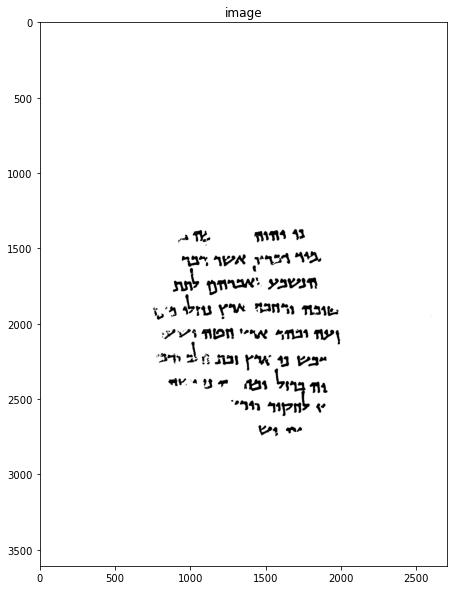

In [33]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import cv2
import numpy as np


easy_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P168-Fg016-R-C01-R01-binarized.jpg'
hard_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P22-Fg008-R-C01-R01-binarized.jpg' 
huge_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P344-Fg001-R-C01-R01-binarized.jpg'
half_sentences_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P106-Fg002-R-C01-R01-binarized.jpg'
divided_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P423-1-Fg002-R-C01-R01-binarized.jpg' 
curly_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P123-Fg002-R-C01-R01-binarized.jpg' 
vague_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P166-Fg007-R-C01-R01-binarized.jpg'


image = cv2.imread(easy_scroll, cv2.IMREAD_UNCHANGED)

plt.figure(figsize=(10,10))
plt.axis()
plt.title("image")
plt.imshow(image, cmap="gray")
plt.show()


In [2]:
#maybe use this instead of the other gray image becaus here the small things are removed and we can find a better path i think.

def thresholding(image):
    _ ,thresh = cv2.threshold(image,80,255,cv2.THRESH_BINARY_INV)
    return thresh

def dilated_image(image):
    thresh_img = thresholding(image)
    kernel = np.ones((4,35), np.uint8)
    dilated = cv2.dilate(thresh_img, kernel, iterations = 1) 
    return dilated

def invert_image(image):
    invert = cv2.bitwise_not(image) 
    return invert


In [3]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from PIL import Image
from skimage.filters import threshold_otsu


def horizontal_projections(image):
    return np.sum(image, axis=1) 


def find_peaks_image(image):
    dilated = dilated_image(image)
    hpp = horizontal_projections(dilated)
    minimum_peak = int((np.max(hpp)-np.min(hpp))/12)
    peaks, _ = find_peaks(hpp, height=minimum_peak, distance=100)
    return hpp, peaks

#Use the calculated peaks to create small areas of where there must be sentences. 
def find_not_peak_regions(hpp, peaks):
    not_peaks = []
    not_peaks_index = []
    count = 0
    x = 0
    line_size = 10
    for i, hppv in enumerate(hpp):
        if x > (len(peaks) - 1):
            not_peaks.append([i, hppv])
        elif i < (peaks[x] - line_size) or i > (peaks[x] + line_size):
            not_peaks.append([i, hppv])
        else:
            count += 1
            if count == ((line_size*2) - 1):
                x += 1
                count = 0
    return not_peaks



#The Hpp_clusters is the black areas such that we have walking regions for the algorithm
#Create walking regions in the image
def get_hpp_walking_regions(peaks_index):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks_index):
        cluster.append(value)

        if index < len(peaks_index)-1 and peaks_index[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []

        #get the last cluster
        if index == len(peaks_index)-1:
            hpp_clusters.append(cluster)
            cluster = []
            
    return hpp_clusters


def white_array(height, width):
    image = np.zeros([height,width],dtype=np.uint8)
    image.fill(255)
    return image


##Copied from the github mentioned above
def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary*1
    return binary

In [4]:
#Copied from the github mentioned above, adjusted for our problem. Created a range of goals.

#a star path planning algorithm 
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):
    
    #print("start: " + str(start))
    #print("end: " + str(goal))
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    lower_limit = goal[0]
    upper_limit = goal[0] + lower_limit 
    
    count = 0
    while oheap:
        count += 1
        
        current = heappop(oheap)[1]
        
        #If there is not a path break after 100 times the length of the input iterations
        if count > goal[1]*30:
            break
            
        #The goal of the path finder can be somewhere in the range of the walking region at the end
        if current[1] == goal[1] and (current[0] > lower_limit and current[0] < upper_limit):
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))      
    return []

In [5]:
#Loop to create the seperate line images
def create_line_image(line_segments):
    line_count = len(line_segments)
    line_image = []

    for line_index in range(line_count-1):
        upper_bound = np.min(line_segments[line_index][:, 0])
        lower_bound = np.max(line_segments[line_index+1][:, 0])
        height = lower_bound - upper_bound
        width = image.shape[1]
        white_line_image = white_array(height, width)
        offset_top = upper_bound


        #Creates white areas around the sentences, such that bits and pieces of other sentences do not get in the line image
        for i in range(white_line_image.shape[0]):
            for j in range(white_line_image.shape[1] -1):
                if (line_segments[line_index][white_line_image.shape[1] - 2 - j][0] - i > upper_bound) or (i + offset_top > line_segments[line_index+1][white_line_image.shape[1] - 2 - j][0]) :              
                    white_line_image[i][j] = 255     
                else:
                    white_line_image[i][j] = image[upper_bound + i][j]

        line_image.append(white_line_image)
#         plt.figure(figsize=(10,10))
#         plt.imshow(white_line_image, cmap="gray")
#         plt.show()
    return line_image


def create_A_star_lines(img, hpp_clusters):
    #Segment all the lines using the A* algorithm
    binary_image = get_binary(img)

    line_segments = []
    for i, cluster_of_interest in enumerate(hpp_clusters):
        nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]

        #The goal given is the middle of the walking region. But we adjusted in the path finder to the complete range.
        path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2), nmap.shape[1]-1)))

        #Finding a path is impossible, then just draw a straight line from begin to end
        if path.shape[0] == 0:
            line_new = []
            size_cluster = int(nmap.shape[0]/2)
            for i in range(nmap.shape[1] - 1):
                line_new.append([size_cluster, nmap.shape[1]-i -1])
                line = []
            line_new = np.asarray(line_new)
            offset_from_top = cluster_of_interest[0]
            line_new[:,0] += offset_from_top
            line_segments.append(line_new)
        else:
            offset_from_top = cluster_of_interest[0]
            path[:,0] += offset_from_top
            line_segments.append(path)
    return line_segments



In [6]:
def line_segmentation(image):
    #Find the horizontal projections and the peaks of the projections
    hpp, peaks = find_peaks_image(image)

    #find all the indexes that do not contain the peak
    not_peaks = find_not_peak_regions(hpp,peaks)
    not_peaks_index = np.array(not_peaks)[:,0].astype(int)


    #Create walking regions for the A* star algorithm path finder
    hpp_clusters = get_hpp_walking_regions(not_peaks_index)

    #dilate the image such that we find a path around the dilation
    dilated = dilated_image(image)

    #invert it back for the path finder because that is build to avoid black pixels
    img = invert_image(dilated)

    #Find the paths for the segmentation
    line_segments = create_A_star_lines(img, hpp_clusters)

    #Create the segmented line images
    line_image = create_line_image(line_segments)
    
    return line_image

# Word segmentation

First we need to downsize the white part in the first and last lines. Because they are huge. 

# Preprocess the lines for word segmentation 

In [7]:
#Remove the top white part of a image
def remove_top_image(image):
    thresh_image = thresholding(image)
    hpp_image = horizontal_projections(thresh_image)
    for i in range(len(hpp_image)):
        if hpp_image[i] != 0:
            image_new = image[i:, :]
            break 
    return image_new

#Remove the bottom white part of a image
def remove_bottom_image(image):
    thresh_image = thresholding(image)
    hpp_image = horizontal_projections(thresh_image)
    for i in range(len(hpp_image)-1, 0, -1):
        if hpp_image[i] != 0:
            image_new = image[:i, :]
            break 
    return image_new  

#Find the vertical image projections
def vertical_projections(image):
    return np.sum(image, axis=0) 

#Remove noise from a image using the meadian blur
def remove_noise(image):
    return cv2.medianBlur(image, 5)

#preprocesses the lines
def pre_process_lines(lines):
    pre_processed_lines = []
    kernel = np.ones((10,10), np.uint8)
    
    for i in range(len(lines)):
        line = lines[i]
        
        #threshold line
        thresh_line = thresholding(line)
        
        #remove noise
        noise_free_line = remove_noise(thresh_line)
        
        #dilate the remaining part
        dilated_line = cv2.dilate(noise_free_line, kernel, iterations = 1)
        
        #append the line
        pre_processed_lines.append(dilated_line)
    return pre_processed_lines

#Remove the white areas that are found in the first and last line
def remove_white_areas_first_last_line(line_image):
    first_line = line_image[0]
    last_line = line_image[len(line_image)-1]

    line_image[0] = remove_top_image(first_line)
    line_image[len(line_image)-1] = remove_bottom_image(last_line)
    return line_image

In [8]:
# Based on white areas pixels that are shorter than a certain amount
def find_words_for_zero_period(image, threshold):
    words = []
    vpp_image = vertical_projections(image)
    
    #find indexes where the vpp is not zero, so there are black pixels
    result_zeros = np.where(vpp_image!=0)
    #print(result_zeros)
    lowest = result_zeros[0][0]
    for i in range(len(result_zeros[0])-1):
        #print("i: " +str(i) + " " +str(result_zeros[0][i]) + " "+ str(lowest))
        diff = result_zeros[0][i+1] - result_zeros[0][i] 
        #skip white periods that are not long enough
        if diff > 1 and diff < threshold:
            continue
        elif diff > 1:
            highest = result_zeros[0][i]
            new_word = [lowest, highest]
            words.append(new_word)
            lowest = result_zeros[0][i+1]
            
    if lowest + 70 < result_zeros[0][len(result_zeros[0])-1]:
            highest = result_zeros[0][len(result_zeros[0])-1]
            new_word = [lowest, highest]
            words.append(new_word)
            lowest = result_zeros[0][i+1]       
    
    return words 

#Create the image for one specific word in which we remove the top and bottom white spaces
def get_word_image(image, index_words):
    words = []
    for i in range(len(index_words)):
        #Get word
        word_new = image[:,index_words[i][0]:index_words[i][1]]
        
        #remove the white area at the top and bottom
        word_bot = remove_bottom_image(word_new)
        word_top = remove_top_image(word_bot)
        
        words.append(word_top)
    return words


#Create the word image for all lines
def create_words(line_image, pre_processed_lines):
    words_per_line = []
    for line in range(len(line_image)):
        index_words = find_words_for_zero_period(pre_processed_lines[line], 10)
        words = get_word_image(line_image[line], index_words) 
        words_per_line.append(words)
    return words_per_line

In [9]:
#Create all the lines and words per line in this part
def get_words_per_line(image):
    #Get the line images for the word segmentation
    line_image = line_segmentation(image)

    line_image = remove_white_areas_first_last_line(line_image)

    #Pre process all the lines such that we can use them for the word and character segmentation
    pre_processed_lines = pre_process_lines(line_image)

    #Get the words that can be segmented on each line
    words_per_line = create_words(line_image, pre_processed_lines)
    return words_per_line


## Character Recognition copied from our github

In [10]:
import cv2
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import os 

In [11]:
# load monkbrill jpg data
data = dict()
data['label'] = []
data['filename'] = []
data['data'] = []   

data_path = "/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/monkbrill2/"
for subdir in os.listdir(data_path):
    if subdir == ".DS_Store":
        continue
    current_path = os.path.join(data_path, subdir)
    for file in os.listdir(current_path):
        im = cv2.imread(os.path.join(current_path, file), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (38, 48)) # (width, height)
        data['label'].append(subdir)
        data['filename'].append(file)
        data['data'].append(im)

In [12]:
# load monkbrill jpg augmented data if yet created
data_augmented = dict()
data_augmented['label'] = []
data_augmented['filename'] = []
data_augmented['data'] = []   

data_path = "/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/monkbrill-jpg-augmented/"
for subdir in os.listdir(data_path):
    current_path = os.path.join(data_path, subdir)
    if subdir == ".DS_Store":
        continue
    for file in os.listdir(current_path):
        im = cv2.imread(os.path.join(current_path, file), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (38, 48)) # (width, height)
        data_augmented['label'].append(subdir)
        data_augmented['filename'].append(file)
        data_augmented['data'].append(im)

In [13]:
# one-hot encode class labels
encoder = LabelBinarizer()
onehot_labels = encoder.fit_transform(data['label'])

# one-hot encode class labels
encoder = LabelBinarizer()
onehot_labels_augmented = encoder.fit_transform(data_augmented['label'])

In [14]:
original_test_data =  np.array(data['data'])
onehot_labels = encoder.fit_transform(data['label'])


X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(data_augmented['data'], onehot_labels_augmented, test_size=0.2, random_state=0, shuffle=True)
X_train_aug = np.array(X_train_aug) / 255.0
y_train_aug = np.array(y_train_aug) 
X_val_aug = np.array(X_val_aug) / 255.0
y_val_aug = np.array(y_val_aug)

In [15]:
# Build LeNet model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(48, 38, 1)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(27, activation='softmax'))

model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 38, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 19, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 15, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 7, 48)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 7, 48)         0         
                                                                 
 flatten (Flatten)    

2022-06-01 17:57:44.362598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 17:57:44.362705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
# Compile and train model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
if not os.path.exists('models'):
        os.makedirs('models')
model_filepath = 'models/LeNet_model.h5'
callback = ModelCheckpoint(filepath=model_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(X_train_aug, y_train_aug, epochs=10, validation_data = (X_val_aug, y_val_aug), callbacks = [callback], verbose=1)

Epoch 1/10


2022-06-01 17:57:44.985457: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-01 17:57:45.184330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2456/2456 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.8866

2022-06-01 17:58:11.033579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2456/2456 [==============================] - 30s 12ms/step - loss: 0.3640 - accuracy: 0.8866 - val_loss: 0.1116 - val_accuracy: 0.9601
Epoch 2/10
2456/2456 [==============================] - 30s 12ms/step - loss: 0.0988 - accuracy: 0.9685 - val_loss: 0.0644 - val_accuracy: 0.9800
Epoch 3/10
2456/2456 [==============================] - 28s 12ms/step - loss: 0.0570 - accuracy: 0.9813 - val_loss: 0.0386 - val_accuracy: 0.9886
Epoch 4/10
2456/2456 [==============================] - 30s 12ms/step - loss: 0.0440 - accuracy: 0.9859 - val_loss: 0.0641 - val_accuracy: 0.9801
Epoch 5/10
2456/2456 [==============================] - 30s 12ms/step - loss: 0.0330 - accuracy: 0.9892 - val_loss: 0.0557 - val_accuracy: 0.9837
Epoch 6/10
2456/2456 [==============================] - 29s 12ms/step - loss: 0.0277 - accuracy: 0.9913 - val_loss: 0.0304 - val_accuracy: 0.9911
Epoch 7/10
2456/2456 [==============================] - 31s 13ms/step - loss: 0.0227 - accuracy: 0.9932 - val_loss: 0.0518 - val_accura

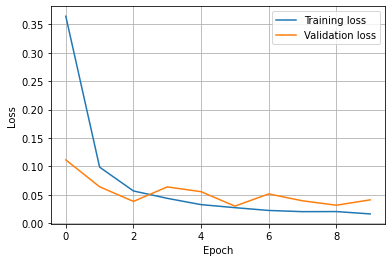

In [17]:
# Plot the loss
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

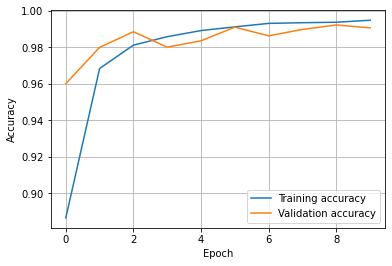

In [18]:
# Plot the accurcy
plt.plot(history.history['accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [19]:
score_original_data = model.evaluate(original_test_data, onehot_labels, verbose = 0)
print('Test loss on original data:', score_original_data [0]) 
print('Test accuracy on original data:', score_original_data [1])

2022-06-01 18:02:43.374792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss on original data: 0.09810806065797806
Test accuracy on original data: 0.999277651309967


In [20]:
print("Generate a prediction")

prediction = model.predict(X_train_aug)
print("prediction:", prediction)

classes = np.argmax(prediction, axis = 1)
# for i in range(len(classes)):
#     print(classes[i])
    
count_arr = np.bincount(classes)
for i in range(len(count_arr)):
    print(str(i) + " number "  + str(count_arr[i])) 

Generate a prediction


2022-06-01 18:02:45.292306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


prediction: [[4.9397401e-21 1.7579590e-22 4.4598380e-20 ... 9.2635196e-18
  3.2015940e-19 1.0000000e+00]
 [2.4278211e-15 4.6331209e-24 2.4086582e-19 ... 1.3505785e-15
  1.1037355e-21 7.1812288e-29]
 [1.7728118e-16 6.7828943e-17 2.3444959e-17 ... 1.2208276e-09
  7.5645863e-19 1.0000000e+00]
 ...
 [5.6373751e-26 2.7632528e-26 1.0000117e-24 ... 8.0733094e-21
  8.2649647e-31 1.4895366e-31]
 [6.1895594e-25 2.1205151e-19 4.5006140e-24 ... 2.7046130e-18
  2.8150861e-25 5.3936594e-22]
 [9.9994528e-01 4.3544329e-22 4.3562619e-12 ... 6.0131216e-18
  3.9070251e-18 2.1807375e-28]]
0 number 2907
1 number 2869
2 number 3048
3 number 2848
4 number 2959
5 number 2898
6 number 2858
7 number 2839
8 number 2898
9 number 2915
10 number 2899
11 number 2952
12 number 2889
13 number 2902
14 number 2972
15 number 2866
16 number 2991
17 number 2854
18 number 2849
19 number 2859
20 number 2925
21 number 2938
22 number 2953
23 number 2883
24 number 2975
25 number 2877
26 number 2952


## Character segmentation

In [21]:
def boundingboxes_letters(image, image_dilated):
    boxcoordinates = []
    words_image = []
    letters = []

    copy = image.copy()
    thresholded = thresholding(image_dilated)

    cnts = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    for c in cnts:
        topleftx, toplefty, width, height = cv2.boundingRect(c)
        next_letter = [topleftx, toplefty, width, height]
        letters.append(next_letter)

    letters = sorted(letters, reverse=False)


    for letter in letters:
        topleftx, toplefty, width, height = letter

        #Reject contours that are too big or small to be likely letters, from average data taken
        #normal minima are height = 27, width = 17
        if height<40 or width<30:
            continue

        #normal maxima are height = 140, width = 80
        if height>300 or width>500:
            continue

        cv2.rectangle(copy, (topleftx, toplefty), (topleftx + width, toplefty + height), (0,0,255), 2)  
        boxcoordinates.append((topleftx, toplefty, width, height))

        character = image[toplefty:toplefty+height, topleftx:topleftx+width]
        words_image.append(character)
    
    return words_image, copy, boxcoordinates

In [22]:
def find_middle_part_letter(image):
    hpp_image = thresholding(image)
    hpp_image = horizontal_projections(hpp_image)
    minimum_peak = int((np.max(hpp_image)-np.min(hpp_image))/3)
    peaks, _ = find_peaks(hpp_image, height=minimum_peak , distance=100)   
    toplefty = max(peaks[0]-20, 0)
    height = min(40, image.shape[0]-toplefty)
    new_image = image[toplefty:toplefty+height, :]
    
    return new_image

def not_bb_divider_peaks(image):
    vpp = vertical_projections(image)
    minimum_peak = int((np.max(vpp)-np.min(vpp))/3)
    peaks, _ = find_peaks(vpp, height=minimum_peak , distance=60)
    new_peaks = []
    for peak in peaks:
        #peaks lower than x value of 30 or 30 from end are not really dividers 
        if peak < 27:
            continue
        elif peak > (image.shape[1] - 27):
            continue
        else:
            new_peaks.append(peak)
        
    return new_peaks
    
def divided_chars(image, peaks):
    chars = []
    first_char = image[:,0:peaks[0]]
    chars.append(first_char)
    for i in range(len(peaks)):
        if i+1 == len(peaks):
            char = image[:,peaks[i]:image.shape[1]]
        else:
            char = image[:,peaks[i]:peaks[i+1]]
        chars.append(char)
    return chars


def not_bb_divided(image):
    character = []
    middle_part = find_middle_part_letter(image)
    peaks_divider = not_bb_divider_peaks(middle_part)
    characters = divided_chars(image, peaks_divider)
    for i in range(len(characters)):
        if characters[i].shape[0] == 0 or characters[i].shape[1] == 0:
            continue 
        else:
            character.append(characters[i])
    return character

In [23]:
def erosion_char_finder(double_char):
    characters = []
    erosion_level = 2
    kernel = np.ones((erosion_level,erosion_level), np.uint8)
    double_char_dilate = cv2.dilate(double_char, kernel, iterations=1)
    chars, test_image, coordinates = boundingboxes_letters(double_char, double_char_dilate)
    
    while len(chars) == 1:
        kernel = np.ones((erosion_level,erosion_level), np.uint8)
        double_char_dilate = cv2.dilate(double_char, kernel, iterations=1)
        chars, test_image, coordinates = boundingboxes_letters(double_char, double_char_dilate)
        erosion_level += 1
        
    for x in range(len(chars)):
        #Too avoid that if we have a bb above another bb that it creates a new unwanted character
        if (x + 1) < len(chars) and coordinates[x+1][0] > coordinates[x][0] and coordinates[x+1][2] < (coordinates[x][2] - coordinates[x+1][0]):
            characters.append(double_char)
            break
        else:
            topleftx = max((coordinates[x][0] - 2), 0)

            #Often if we have two conjoint letters we have a too small bounding box for the last letter
            #Therefore we take the full bb of everything from the last letter onwards. 
            if x == (len(chars) -1):
                width = double_char.shape[1]-coordinates[x][0]
            else:
                width = min((coordinates[x][2] + 2), (double_char.shape[1]-coordinates[x][0]))
            new_char = double_char[:, topleftx:topleftx+width]
            characters.append(new_char)
    return characters

def find_characters_in_word(word):
    #character finder in total:
    word_copy = word.copy()

    #the first time we have a word we dilate such that we can find letters that are already seperated form others
    kernel = np.ones((3,3), np.uint8)
    word_copy_dilate = cv2.erode(word_copy, kernel, iterations=1)

    char, word_bb_image, coordinates = boundingboxes_letters(word_copy, word_copy_dilate)    
    characters = []

    #If we do not find boundingboxes within the word, the word itself is a letter
    if len(char) == 0:
        characters.append(word_bb_image)
    else:
        for i in range(len(char)):
            if char[i].shape[1] > 85:
                new_char_bb = erosion_char_finder(char[i])
                if len(new_char_bb) == 0:
                    #Still searching for the best parameter for this
                    if char[i].shape[1] > 90:
                        #this is a handcrafted divider
                        characters_handcrafted_div = not_bb_divided(char[i])
                        for u in range(len(characters_handcrafted_div)):
                            characters.append(characters_handcrafted_div[u])
                    else:
                        characters.append(char[i])
                else:
                    for x in range(len(new_char_bb)):
                        if new_char_bb[x].shape[1] > 90:
                            new_new_char_bb = erosion_char_finder(new_char_bb[x])
                            if len(new_new_char_bb) == 0:
                                if new_char_bb[x].shape[1] > 86:
                                    characters_handcrafted_div = not_bb_divided(new_char_bb[x])
                                    for u in range(len(characters_handcrafted_div)):
                                        characters.append(characters_handcrafted_div[u])
                                else:
                                    characters.append(new_char_bb[x])
                            else:
                                if len(new_new_char_bb) == 1:
                                    if new_new_char_bb[0].shape[1] > 85:
                                        characters_handcrafted_div = not_bb_divided(new_char_bb[0])
                                        for u in range(len(characters_handcrafted_div)):
                                            characters.append(characters_handcrafted_div[u])
                                else:
                                    for y in range(len(new_new_char_bb)):
                                        characters.append(new_new_char_bb[y])
                        else:
                            characters.append(new_char_bb[x])
            else:
                characters.append(char[i])
    return characters

## Final characters for all words still need to implement the loops here and stuff

In [24]:
#To find the all the characters in a line
def characters_per_line(words):
    char_per_word = []
    for i in range(len(words)):
        characters = find_characters_in_word(words[i])
        char_per_word.append(characters)
    return char_per_word
    

Word: 0
Character 0


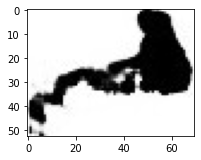

Word: 1
Character 0


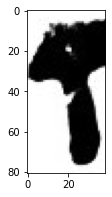

Character 1


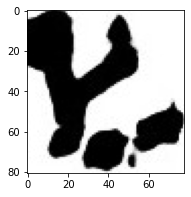

Word: 2
Character 0


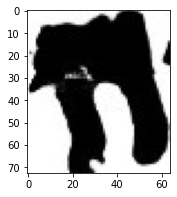

Character 1


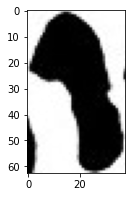

Character 2


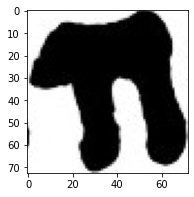

Character 3


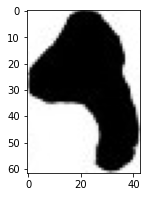

Word: 3
Character 0


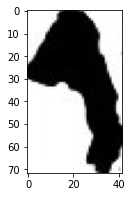

Character 1


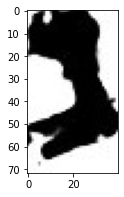

In [25]:
# print all characters from a specific line 

words_per_line = get_words_per_line(image)

line_characters = characters_per_line(words_per_line[0])

for i in range(len(line_characters)):
    print("Word: " + str(i))
    for j in range(len(line_characters[i])):
        print("Character "+ str(j))
        plt.figure(figsize=(3,3))
        plt.imshow(line_characters[i][j], cmap="gray")
        plt.show()
        
        

## Now we can resize and input the seperate charachters into the model and make predictions

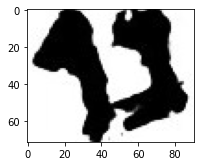

Character 0


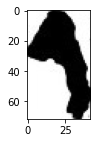

Character 1


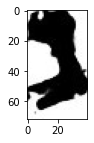

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]]
[12  7]


In [35]:
#Line_charachters = de woorden van line 1 pakt die nu 
line_characters = characters_per_line(words_per_line[0])

#we testen hier woord 6 van lijn 1
test_word = line_characters[3]


#foto van de letters als woord
plt.figure(figsize=(3,3))
plt.imshow(words_per_line[0][3], cmap="gray")
plt.show()

for j in range(len(test_word)):
    print("Character "+ str(j))
    plt.figure(figsize=(2,2))
    plt.imshow(test_word[j], cmap="gray")
    plt.show()


char_resized = []

for i in range(len(test_word)):
    test_char_resized = cv2.resize(test_word[i], (38, 48))
    char_resized.append(test_char_resized)
    

array = np.array(char_resized) 

#De predictions
predictions = model.predict(array)
print(predictions)
classes = np.argmax(predictions, axis = 1)
print(classes)